## Zadanie biznesowe
Stworzenie algorytmu przewidującego rezultat zakończenia obecnej sesji użytkownika, który przyjmuje postać 0 albo 1, gdzie 0 oznacza brak zakupu, a 1 oznacza zakup. W takiej sytuacji konsultanci szybciej mogliby zareagować i rozwiązać potencjalny problem klienta.

## Obecna sytuacja
Jesteśmy w stanie analizować jedynie logi. Widzimy, że klienci bardzo często nie są pewni co do zakupu. Jest to potencjalna strata klienta dla firmy. Konsultanci nie są w stanie pomóc i doradzić najbardziej perspektywicznym klientom.

## Biznesowe kryterium sukcesu
Dane przedsiębiorstwo ma ograniczoną ilość konsultantów. Chcemy zmaksymalizować zysk, który są wstanie wygenerować. W związku z tym model powinien dobrze przewidywać sesje, które zakończą się zakupem, aby nasi konsultanci mogli zająć się najbardziej obiecującymi sesjami klientów. Mogą wówczas oferować klientom bardziej korzystne zniżki, bądź rekomendacje, przekonujące klienta do zakupu. Zwiększą tym samym zyski firmy, co jest naszym celem. Do tej pory konsultanci bazowali na długości sesji klientów.

## Zadanie modelowania
Przygotowanie klasyfikatora binarnego wskazującego 1 dla sesji mającej zakończyć się zakupem lub 0 w przeciwnym wypadku, na podstawie logów z sesji klientów sklepu.

##### Wejście
Sekwencja logów z sesji klienta


##### Wyjście
1 lub 0

1 - sesja zakończy się zakupem
0 - sesja nie zakończy się zakupem

### Dane do modelowania
+ Logi z informacjami o tym jakie przedmioty były oglądane i kupowane przez klientów w sesji oraz posiadana zniżka
+ Katalog z dostępnymi w ofercie przedmiotami i ich cenami
+ Dane klientów sklepu zawierające ich imię oraz nazwisko

### Analityczne kryterium sukcesu
Przewidywania naszego modelu muszą być lepsze od prostego modelu, który przewiduje czy sesja zakończy się zakupem na podstawie czasu jej trwania.

Zakładając, iż taki prosty model dla sesji trwającej dłużej niż średni czas spędzany na sesję, uzyskany bazując na dostępnych danych, przewiduje pozytywne jej zakończenie i oznaczając stosunek poprawnie przewidzonych w ten sposób sesji do wszystkich sesji zakończonych zakupem jako $\alpha$

Skuteczność naszego modelu powinna przekraczać ten współczynnik

\begin{align*}
$\frac{# poprawne \quad przewidzenie \quad zakupu}{# wszystkie \quad sesje \quad zakończone \quad zakupem} \ge \alpha$
\end{align*}

# Wstepna analiza danych

### Otrzymaliśmy logi dotyczące:
- produktów
- sesji użytkowników
- dostaw
- użytkowników

Z tabeli dostaw nie będziemy korzystać. Nie ma w niej informacji pomocnych do rozwiązania naszego zadania.

In [880]:
import pandas as  pd
import re
import ast

In [881]:
def get_data(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    json_formatted = '['
    for line in lines:
        json_formatted += line + ','
    json_formatted = json_formatted[:-1] + ']'
    json_formatted = re.sub('null', 'None', json_formatted)
    return ast.literal_eval(json_formatted)

In [882]:
df_products = pd.DataFrame(get_data('products.jsonl'))
df_sessions = pd.DataFrame(get_data('sessions.jsonl'))
df_users = pd.DataFrame(get_data('users.jsonl'))

df_sessions['timestamp'] = pd.to_datetime(df_sessions['timestamp'])

df_list = [df_products, df_sessions, df_users]

In [883]:
def look_for_nulls(df, column):
    not_nulls = df[df[column].notna()].shape[0]
    nulls = df[df[column].isna()].shape[0]
    return not_nulls, nulls

def get_unique_values(df, column):
    return df[column].unique()

## Sprawdzanie poprawności i występowania braków w danych

In [884]:
for df in df_list:
    for column in df.columns:
        not_nulls, nulls = look_for_nulls(df, column)
        uniques = get_unique_values(df, column)
        print(f'Nulls in column {column}: {nulls}')
        print(f'Not nulls in column {column}: {not_nulls}')
        print('_')

Nulls in column product_id: 0
Not nulls in column product_id: 319
_
Nulls in column product_name: 0
Not nulls in column product_name: 319
_
Nulls in column category_path: 0
Not nulls in column category_path: 319
_
Nulls in column price: 0
Not nulls in column price: 319
_
Nulls in column session_id: 0
Not nulls in column session_id: 34374
_
Nulls in column timestamp: 0
Not nulls in column timestamp: 34374
_
Nulls in column user_id: 0
Not nulls in column user_id: 34374
_
Nulls in column product_id: 0
Not nulls in column product_id: 34374
_
Nulls in column event_type: 0
Not nulls in column event_type: 34374
_
Nulls in column offered_discount: 0
Not nulls in column offered_discount: 34374
_
Nulls in column purchase_id: 29242
Not nulls in column purchase_id: 5132
_
Nulls in column user_id: 0
Not nulls in column user_id: 200
_
Nulls in column name: 0
Not nulls in column name: 200
_
Nulls in column city: 0
Not nulls in column city: 200
_
Nulls in column street: 0
Not nulls in column street: 2

In [885]:
# Unikalne wartosci dla kolumny event_type
get_unique_values(df_sessions, 'event_type')

array(['VIEW_PRODUCT', 'BUY_PRODUCT'], dtype=object)

In [886]:
# Sprawdzenie czy cena i znizka jest z dobrego przedzialu
price_uniques = get_unique_values(df_products, 'price')
discount_uniques = get_unique_values(df_sessions, 'offered_discount')
sum(price_uniques <= 0) + sum(discount_uniques < 0) + sum(discount_uniques > 100)

0

Możemy zauważyć, że dane nie mają w sobie błędów (np. ujemnej ceny). Nie ma również brakujących danych. Jedyna taka sytuacja jest w kolumnie purchase_id,
ale jest to poprawne. Null w takiej sytuacji oznacza brak zakupu w danej chwili. Dodatkowo kolumna event_type ma tylko 2 możliwe wartości VIEW_PRODUCT oraz BUY_PRODUCT
co jest korzystne w dalszej pracy.

# Badanie współzależności danych
Przede wszystkim zamienimy wartości w kolumnie purchase_id na wartości binarne, 0 - brak zakupu, 1 - zakup

In [887]:
import scipy.stats as stats
import copy

df = copy.deepcopy(df_sessions)
df["purchase_id"] = df["purchase_id"].notna().astype(int)
df["event_type"] = (df["event_type"] == "BUY_PRODUCT").astype(int)

## Współczynnik korelacji punktowo-dwuseryjnej między ceną a faktem zakupu
Współczynnik ten służy do pomiaru relacji między zmienną ciągłą i zmienną binarną.

In [888]:
df_merged = copy.deepcopy(df_products)
df_merged = df_merged.drop(labels=['product_name'], axis=1)
df_merged = pd.merge(df, df_merged, on='product_id', how='left')
df_merged = df_merged.drop(labels='timestamp', axis=1)

stats.pointbiserialr(df_merged["purchase_id"], df_merged["price"])

PointbiserialrResult(correlation=-0.0317618397026818, pvalue=3.862217811095643e-09)

## Współczynnik informacji wzajemnej
W tym przypadku stosujemy go dla zmiennych dyskretnych (nieporządkowych). Jedyna zmienna dyskretna porządkowa (analizowana poniżej) to atrybut 'offered_discount'.

In [889]:
from sklearn.metrics import mutual_info_score
import itertools

def get_mi(df, columns):
    combinations = list(itertools.combinations(columns, 2))
    result = []
    df['category_path'] =df['category_path'].astype("category")
    df['category_path'] =df['category_path'].cat.codes
    for com in combinations:
        mi = mutual_info_score(df[com[0]], df[com[1]])
        result.append([mi, com[0], com[1]])
    return result

df_pom = copy.deepcopy(df_merged)

# Atrybuty dyskretne
mi_to_check = ['user_id', 'product_id', 'event_type', 'offered_discount', 'purchase_id', 'category_path']

results = get_mi(df_pom, mi_to_check)
for result in results:
    print(result)

[0.271584888917021, 'user_id', 'product_id']
[0.008827171948987661, 'user_id', 'event_type']
[0.06672958806255558, 'user_id', 'offered_discount']
[0.008827171948987661, 'user_id', 'purchase_id']
[0.17662644806499578, 'user_id', 'category_path']
[0.04602276334340634, 'product_id', 'event_type']
[0.005211114984208808, 'product_id', 'offered_discount']
[0.04602276334340634, 'product_id', 'purchase_id']
[2.5820673067749498, 'product_id', 'category_path']
[2.8427119742054086e-05, 'event_type', 'offered_discount']
[0.421491009242167, 'event_type', 'purchase_id']
[0.045402191129520604, 'event_type', 'category_path']
[2.8427119742054086e-05, 'offered_discount', 'purchase_id']
[0.0033685476313884827, 'offered_discount', 'category_path']
[0.045402191129520604, 'purchase_id', 'category_path']


In [890]:
# Jaki wplyw ma ilosc ogladanych produktow na fakt zakupu
df_pom = copy.deepcopy(df_merged)
df_pom = df_pom.groupby('session_id')['purchase_id'].agg(['sum', 'count'])
print(mutual_info_score(df_pom['sum'], df_pom['count']), 'purchase_id, products_seen' )

0.1596191476457325 purchase_id, products_seen


In [891]:
# Jaki wplyw ma miasto na fakt zakupu
d = df.merge(df_users, on='user_id', how='left')
print(mutual_info_score(d['purchase_id'], d['city']), 'purchase_id, city' )

0.006154445022178767 purchase_id, city


# Wnioski
### Uwaga: purchase_id zamieniono na zmienną binarną, informującą czy dokonano zakupu
W analizie tego współczynnika pomijamy takie atrybuty jak np. session_id. Jest to atrybut ściśle pomocniczy, który służy tylko do grupowania wierszy w danych. Największe wartości współczynnik informacji wzajemnej przyjmuje dla pary atrybutów [product_id, category_path]. Wynika to oczywiście z faktu ścisłego powiązania produktów z ich kategorią. Całkiem spore wartości przyjmował również dla par [user_id, product_id], [user_id, category_path], [event_type, purchase_id]. Interesuje nas przede wszystkim wartość współczynnika dla pary z 'purchase_id', ponieważ atrybut ten informuje nas o zakupie produktu. Kolejne wartości dla pary z purchase_id:
- user_id --> 0.0088
- product_id --> 0.046
- offered_discount --> około 0.00003
- category_path --> 0.0454
- products_seen --> 0.1596
- city --> 0.0062

Pomijamy atrybut event_type, ponieważ jest on tożsamościowy z atrybutem purchase_id. Wartość "VIEW_PRODUCT" zawsze wiążę z tym, że purchase_id ma wartośc null (0). W innym przypadku
ma przypisaną wartość “BUY_PRODUCT” (1 po zmianach).

Możemy zauważyć, że całkiem wysoki współczynnik jest dla pary [purchase_id, products_seen], [purchase_id, product_id] oraz [purchase_id, category_path]. Dla 3 pozostałych atrybutów jest on o wiele mniejszy, ale ciągle niezerowy.

Dodatkowo wcześniej wyliczony współczynnik korelacji punktowo-dwuseryjnej wynosił -0.0317 dla pary [purchase_id, price].

Z uzyskanych wartości współczynnika wartości wzajemnej i współczynnika korelacji punktowo-dwuseryjnej wynika, że atrybuty nie niosą bardzo dużej informacji o końcowym fakcie zakupy w obrębie danej sesji. Natomiast kombinacja wszystkich tych atrybutów może dawać całkiem dobre rezultaty.

# Rozkłady atrybutów

## Produkty

In [892]:
import matplotlib.pyplot as plt
df_products["price"].describe()

count     319.000000
mean      247.787962
std       813.788548
min         1.000000
25%        24.990000
50%        41.000000
75%        92.995000
max      7639.000000
Name: price, dtype: float64

<AxesSubplot:>

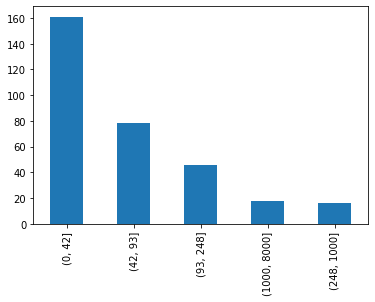

In [893]:
cut_bins = [0, 42, 93, 248, 1000, 8000]
pd.cut(df_products["price"], bins=cut_bins).value_counts().plot(kind="bar")

Zauważamy, iż zdecydowanie najwięcej jest produktów w niskich cenach, 75% produktów jest w cenie poniżej 93. Także nasz sklep głównie nastawia się na sprzedaż tańszych produktów.

<BarContainer object of 4 artists>

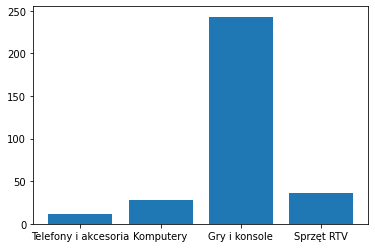

In [894]:
root_categories = df_products['category_path'].str.split(";").str.get(0).unique()
num_products = []
for i in range(len(root_categories)):
    num_products.append(df_products[df_products['category_path'].str.startswith(root_categories[i])].shape[0])
plt.bar(root_categories, num_products)

Zauważamy, że zdecydowana większość naszych produktów należy do kategorii Gry i konsole co zgadzałoby się też z naszymi obserwacjami zwiazanymi z ceną, gry nie są zbyt drogie w porównaniu do sprzętu co skutkuje tym, iż dominujące są przedmioty o niższych cenach.

Ciekawą obserwacją może być to, iż jeżeli w sesji występuje zakup to jest to zawsze jej ostatni krok.

In [895]:
new_df = copy.deepcopy(df_sessions)
new_df['purchase_id'] = new_df['purchase_id'].notna().astype(int)
new_df = pd.merge(new_df, df_products, on='product_id', how="left")
new_df = new_df.groupby('session_id').tail(1)

df_cat = new_df.drop(columns=['timestamp', 'user_id', 'event_type', 'offered_discount', 'product_id', 'price', 'product_name'])
df_cat['category_path'] = df_cat['category_path'].str.split(';').str.get(0)
df_cat = df_cat.rename(columns={'purchase_id':'purchase', 'category_path':'root_category'})
df_cat

,session_id,purchase,root_category
5,124,1,Sprzęt RTV
10,125,1,Gry i konsole
12,126,1,Sprzęt RTV
14,127,1,Sprzęt RTV
17,128,1,Telefony i akcesoria
...,...,...,...
34356,9458,1,Telefony i akcesoria
34364,9459,1,Komputery
34366,9460,1,Gry i konsole
34371,9461,0,Komputery


<AxesSubplot:xlabel='root_category'>

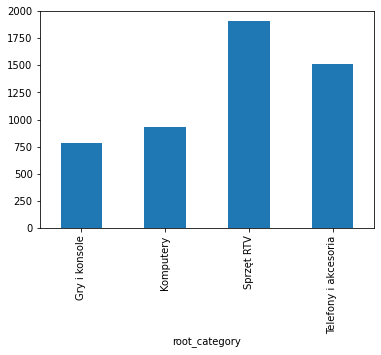

In [896]:
groups_sum = df_cat.groupby('root_category')['purchase'].sum()
groups_sum.plot(kind="bar")

Mimo, że najwiecej w ofercie sklepu znajduje się gier oraz konsol to nie ma to pokrycia w zakupach jakie dokonują klienci. Gry i konsole są najrzadziej kupowanymi produktami.

# Rozkład danych w czasie

### Ilość sesji zależnie od miesiąca

<AxesSubplot:xlabel='month'>

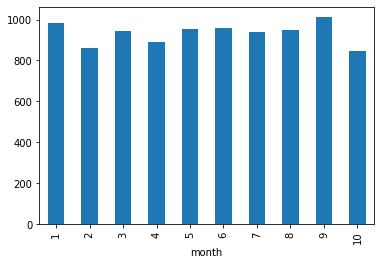

In [897]:
d = copy.deepcopy(new_df)
d['month'] = pd.DatetimeIndex(d['timestamp']).month
d.groupby('session_id')
d.groupby('month').size().plot(kind='bar')

### Ilość dokonanych zakupów zależnie od miesiąca

<AxesSubplot:xlabel='month'>

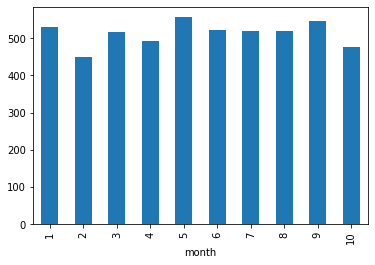

In [898]:
d = copy.deepcopy(new_df)
d = d.loc[d['purchase_id'] == 1]
d['month'] = pd.DatetimeIndex(d['timestamp']).month
d.groupby('session_id')
d.groupby('month').size().plot(kind='bar')

### Ilość sesji zależnie od dnia tygodnia

<AxesSubplot:xlabel='day'>

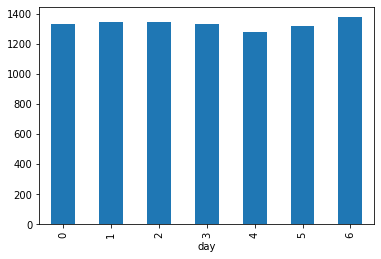

In [899]:
d = copy.deepcopy(new_df)
d['day'] = pd.DatetimeIndex(d['timestamp']).dayofweek
d.groupby('session_id')
d.groupby('day').size().plot(kind='bar')

### Ilość sesji zależnie od godziny

<AxesSubplot:xlabel='hour'>

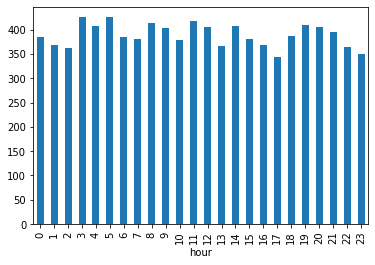

In [900]:
d = copy.deepcopy(new_df)
d['hour'] = pd.DatetimeIndex(d['timestamp']).hour
d.groupby('session_id')
d.groupby('hour').size().plot(kind='bar')

### Ilość zakupów zależnie od godziny

<AxesSubplot:xlabel='hour'>

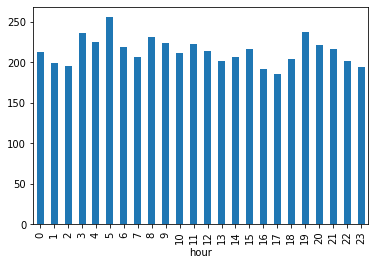

In [901]:
d = copy.deepcopy(new_df)
d = d.loc[d['purchase_id'] == 1]
d['hour'] = pd.DatetimeIndex(d['timestamp']).hour
d.groupby('session_id')
d.groupby('hour').size().plot(kind='bar')

Możemy zauważyć, że w każdej wcześniej wymienionej sytuacji dane są rozłożonone w miarę jednostajnie, niezależnie od jakiegokolwiek warunku związanego z czasem.

# Użytkownicy

In [902]:
df_sex = copy.deepcopy(df_users)
df_sex = df_sex.drop(columns=['city', 'street'])
df_sex['name'] = df_sex['name'].str.split(' ').str.get(0)
df_sex['name'] = df_sex['name'].str.endswith('a')
df_sex = df_sex.rename(columns={'name':'sex'})
df_sex['sex'] = df_sex['sex'].astype(int)
df_sex

,user_id,sex
0,102,0
1,103,0
2,104,1
3,105,0
4,106,0
...,...,...
195,297,1
196,298,1
197,299,0
198,300,0


SEX: 0 - mężczyźni, 1 - kobiety

<BarContainer object of 2 artists>

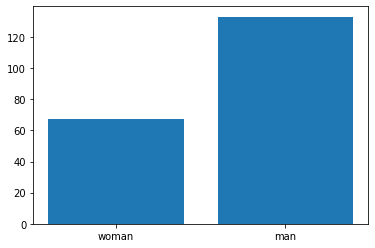

In [903]:
df_sex['sex'] = df_sex['sex'].astype(bool)
sex = ['woman', 'man']
num_sex = [df_sex['sex'].sum(), (~df_sex['sex']).sum()]
df_sex['sex'] = df_sex['sex'].astype(int)
plt.bar(sex, num_sex)

In [904]:
num_sex[1]/num_sex[0]

1.9850746268656716

Zauważamy, że naszymi klientami w większości są mężczyźni jest ich prawie dwukrotnie więcej od kobiet.

In [905]:
df_comp_sex = copy.deepcopy(new_df)
df_comp_sex = df_comp_sex.drop(columns=['timestamp', 'product_id', 'event_type', 'offered_discount', 'product_name', 'category_path', 'price'])
df_comp_sex = df_comp_sex.merge(df_sex, on='user_id', how='left')

df_comp_sex = df_comp_sex.loc[df_comp_sex['purchase_id'] == 1]
df_comp_sex

,session_id,user_id,purchase_id,sex
0,124,102,1,0
1,125,102,1,0
2,126,102,1,0
3,127,102,1,0
4,128,102,1,0
...,...,...,...,...
9332,9456,301,1,0
9334,9458,301,1,0
9335,9459,301,1,0
9336,9460,301,1,0


<AxesSubplot:xlabel='sex'>

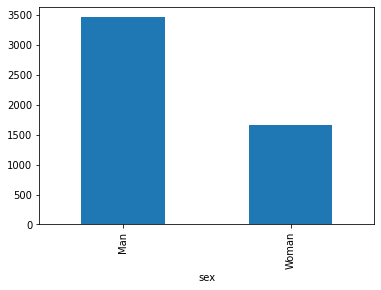

In [906]:
groups_sum = df_comp_sex.groupby('sex').purchase_id.sum().rename(index={False:'Man', True:'Woman'})
groups_sum.plot(kind="bar")

In [907]:
groups_sum[0]/groups_sum[1]

2.074895146794488

Możemy zauważyć, iż stosunek liczby zakupionych produktów przez mężczyzn oraz kobiety ( =2.075 ) nie odbiega w znaczący sposób od stosunku mężczyzn oraz kobiet będących klientami ( =1.985 ), co wskazuje na to, że nie możemy doszukiwać się zależności między zakupem przedmiotu a płcią klienta.

## Czas trwania sesji

In [908]:
df_time = copy.deepcopy(df_sessions)
df_time['purchase_id'] = df_time['purchase_id'].notna().astype(int)
df_time = df_time[['session_id', 'timestamp', 'purchase_id']].copy()
df_time

,session_id,timestamp,purchase_id
0,124,2021-02-13 05:31:27,0
1,124,2021-02-13 05:34:39,0
2,124,2021-02-13 05:38:20,0
3,124,2021-02-13 05:39:02,0
4,124,2021-02-13 05:42:43,0
...,...,...,...
34369,9461,2021-07-25 11:44:35,0
34370,9461,2021-07-25 11:46:38,0
34371,9461,2021-07-25 11:48:24,0
34372,9462,2021-08-19 21:15:08,0


In [909]:
session_start = df_time.groupby('session_id').head(1)
session_start.reset_index(drop=True, inplace=True)
session_start

,session_id,timestamp,purchase_id
0,124,2021-02-13 05:31:27,0
1,125,2021-10-27 07:55:18,0
2,126,2021-02-18 20:47:28,0
3,127,2021-04-27 23:25:59,0
4,128,2021-01-20 20:03:25,0
...,...,...,...
9334,9458,2021-05-27 22:47:59,0
9335,9459,2021-09-03 11:53:29,0
9336,9460,2021-08-03 20:38:56,0
9337,9461,2021-07-25 11:39:28,0


In [910]:
session_end = df_time.groupby('session_id').tail(1)
session_end.reset_index(drop=True, inplace=True)
session_end

,session_id,timestamp,purchase_id
0,124,2021-02-13 05:47:03,1
1,125,2021-10-27 08:06:00,1
2,126,2021-02-18 20:51:33,1
3,127,2021-04-27 23:26:13,1
4,128,2021-01-20 20:08:47,1
...,...,...,...
9334,9458,2021-05-27 22:53:02,1
9335,9459,2021-09-03 12:11:06,1
9336,9460,2021-08-03 20:42:42,1
9337,9461,2021-07-25 11:48:24,0


In [911]:
session_time = session_end['timestamp'] - session_start['timestamp']
session_time

0      0 days 00:15:36
1      0 days 00:10:42
2      0 days 00:04:05
3      0 days 00:00:14
4      0 days 00:05:22
             ...      
9334   0 days 00:05:03
9335   0 days 00:17:37
9336   0 days 00:03:46
9337   0 days 00:08:56
9338   0 days 00:02:26
Name: timestamp, Length: 9339, dtype: timedelta64[ns]

In [912]:
session_time.describe()

count                         9339
mean     0 days 00:06:48.033515365
std      0 days 00:06:57.708777602
min                0 days 00:00:00
25%                0 days 00:01:42
50%                0 days 00:04:17
75%                0 days 00:09:56
max                0 days 00:37:43
Name: timestamp, dtype: object

In [913]:
session_time.mean()

Timedelta('0 days 00:06:48.033515365')

Średni czas sesji wynosi 6 minut 48 sekund, ta informacja przyda sie nam do tworzenia modelu naiwnego

In [914]:
session_end_purchase = session_end.loc[session_end['purchase_id']==1]
session_end_purchase

,session_id,timestamp,purchase_id
0,124,2021-02-13 05:47:03,1
1,125,2021-10-27 08:06:00,1
2,126,2021-02-18 20:51:33,1
3,127,2021-04-27 23:26:13,1
4,128,2021-01-20 20:08:47,1
...,...,...,...
9332,9456,2021-09-06 10:40:35,1
9334,9458,2021-05-27 22:53:02,1
9335,9459,2021-09-03 12:11:06,1
9336,9460,2021-08-03 20:42:42,1


In [915]:
session_end_no_purchase = session_end.loc[session_end['purchase_id']==0]
session_end_no_purchase

,session_id,timestamp,purchase_id
9,133,2021-05-01 19:50:14,0
10,134,2021-10-05 17:45:45,0
11,135,2021-02-04 02:47:12,0
15,139,2021-06-01 09:22:36,0
16,140,2021-01-19 05:26:49,0
...,...,...,...
9317,9441,2021-09-28 16:42:39,0
9318,9442,2021-10-20 18:28:58,0
9325,9449,2021-09-21 12:17:31,0
9333,9457,2021-06-05 04:31:08,0


# Wyznaczmy współczynnik $alpha$ na podstawie dostępnych danych

Liczba wszystkich sesji zakończonych zakupem

In [916]:
all_purchases = session_end_purchase.shape[0]
all_purchases

5132

Liczba sesji zakończonych zakupem przewidzianych przez model naiwny, czyli takich dla których czas sesji jest większy od czasu średniego

In [917]:
session_time_purchase = session_end_purchase.merge(session_start[['session_id','timestamp']], on='session_id', how='left')
session_time_purchase = session_time_purchase['timestamp_x'] - session_time_purchase['timestamp_y']
session_time_purchase = session_time_purchase.loc[session_time_purchase > session_time.mean()]
naive_purchase_preds = session_time_purchase.shape[0]
naive_purchase_preds

1539

### Wartość współczynnika alpha dla posiadanych danych

In [918]:
alpha = naive_purchase_preds/all_purchases
alpha

0.29988308651597817

In [919]:
session_time_purchase = session_end_purchase.merge(session_start[['session_id','timestamp']], on='session_id', how='left')
session_time_purchase = session_time_purchase['timestamp_x'] - session_time_purchase['timestamp_y']
session_time_purchase

0      0 days 00:15:36
1      0 days 00:10:42
2      0 days 00:04:05
3      0 days 00:00:14
4      0 days 00:05:22
             ...      
5127   0 days 00:03:23
5128   0 days 00:05:03
5129   0 days 00:17:37
5130   0 days 00:03:46
5131   0 days 00:02:26
Length: 5132, dtype: timedelta64[ns]

In [920]:
session_time_purchase.mean()

Timedelta('0 days 00:06:24.740646921')

In [921]:
session_time_no_purchase = session_end_no_purchase.merge(session_start[['session_id','timestamp']], on='session_id', how='left')
session_time_no_purchase = session_time_no_purchase['timestamp_x'] - session_time_no_purchase['timestamp_y']
session_time_no_purchase

0      0 days 00:07:27
1      0 days 00:20:39
2      0 days 00:05:52
3      0 days 00:08:28
4      0 days 00:22:40
             ...      
4202   0 days 00:04:22
4203   0 days 00:26:25
4204   0 days 00:04:20
4205   0 days 00:03:44
4206   0 days 00:08:56
Length: 4207, dtype: timedelta64[ns]

In [922]:
session_time_no_purchase.mean()

Timedelta('0 days 00:07:16.447825053')

In [923]:
session_time_no_purchase.mean() - session_time_purchase.mean()

Timedelta('0 days 00:00:51.707178132')

Analizując czas spędzany w sesji przez klientów i wynik tej sesji (zakup lub jego brak) zauważamy, że wbrew naszej pierwotnej intuicji sesja zakończona zakupem trwa średnio o 51 sekund krócej niż sesja, która zakupem się nie zakończyła. Możemy to argumentować tym, iż klient który ma zamiar coś kupić ma bardziej sprecyzowane wymagania i spędza na stronie mniej czasu.

# Ogólne podsumowanie
1. Dane są kompletne - brak nulli w wierszach oraz poprawne - np. brak ujemnej ceny.
2. Na podstawie danych jesteśmy w stanie oszacować współczynnik alfa, który wynosi około 0,3.
3. Współczynnik informacji wzajemnej i korelacji punktowo-dwuseryjnej wskazują dosyć małe wartości. Natomiast kombinacja wszystkich atrybutów, pomimo małych wartości współczynnika, może dawać całkiem dobre rezultaty.
4. Uważamy, że na podstawie danych jesteśmy w stanie stworzyć model, który spełni kryterium biznesowe jak i analityczne. Nie będzie to model bezbłędny, ale może on istotnie usprawnić pracę konsultantów i zmaksymalizować zysk jaki generują.